# Catchment Characteristics

This notebook will calculate the following parameters:
- mean slope
- mean elevation
- longest travel distance
- steepest slope

In [71]:
# import required packages
import pandas as pd
import numpy as np
import math

# advanced statistics library
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mp
import matplotlib.colors as colors

# SEE COMMENTS ABOUT PYSHEDS LIBRARY IN NEXT CELL
from pysheds.grid import Grid
import warnings
warnings.filterwarnings('ignore')

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import LinearColorMapper, LogTicker, ColorBar, BasicTickFormatter
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [91]:
# grid = Grid.from_raster('data/n45w125_con_grid/n45w125_con/n45w125_con', data_name='dem')
grid = Grid.from_ascii(path='../../data/notebook_5_data/n49w1235_con_grid.asc', 
                       data_name='dem')

In [73]:
# reset the nodata from -32768 so it doesn't throw off the 
# DEM plot
grid.nodata = 0

In [74]:
# store the extents of the map
map_extents = grid.extent
min_x, max_x, min_y, max_y = map_extents

In [75]:
# set bokeh plot tools
tools = "pan,wheel_zoom,box_zoom,reset,tap"

# show the precision of the decimal coordinates
# in the plot to 5 decimal places
TOOLTIPS = [
    ("(x,y)", "($x{1.11111}, $y{1.11111})"),
]

# create a figure, setting the x and y ranges to the appropriate data bounds
p1 = figure(title="DEM of the Lower Mainland of BC.  Hover to get coordintes.", plot_width=600, plot_height=int(400),
            x_range = map_extents[:2], y_range = map_extents[2:], 
            tools=tools, tooltips=TOOLTIPS)

# map elevation to a colour spectrum
color_mapper = LinearColorMapper(palette="Magma256", low=-200, high=2400)

# np.flipud flips the image data on a vertical axis
adjusted_img = [np.flipud(grid.dem)]  

p1.image(image=adjusted_img,   
         x=[min_x],               # lower left x coord
         y=[min_y],               # lower left y coord
         dw=[max_x-min_x],        # *data space* width of image
         dh=[max_y-min_y],        # *data space* height of image
         color_mapper=color_mapper
)

color_bar = ColorBar(color_mapper=color_mapper, #ticker=Ticker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

p1.add_layout(color_bar, 'right')


#show(p1)

# -123.15512, 49.41293
#-123.14657, 49.41080
#-123.14350, 49.40251

In [76]:
grid.resolve_flats('dem', out_name='inflated_dem')

In [77]:
#         N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

In [78]:
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)

### INPUT LOCATION COORDINATES HERE

In [79]:
# Specify the Point of Concentration (POC) / Catchment Outlet (a.k.a. pour point) 

#insert coordinates of outlet/intake
y, x = 49.457422, -123.222197

# Delineate the catchment
grid.clip_to('dem')
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)

In [80]:
# Clip the bounding box to the catchment we've chosen
grid.clip_to('catch', pad=(0,0,0,0))

In [81]:
# Create a view of the catchment
catch = grid.view('catch', nodata=np.nan)

In [82]:
# check the shape to see if we've estimated close enough to the 
# actual river to delineate the catchment successfully
print(catch.shape)
# if we get dimensions of < 10, we've missed and instead pointed at some 
# little hillslope

(37, 53)


In [83]:
print(grid.extent)
ext_1 = grid.extent

(-123.222500000111, -123.177500000129, 49.44583333315501, 49.477499999809005)


In [84]:
grid.accumulation(data='catch', dirmap=dirmap, out_name='acc')

In [85]:
grid.flow_distance(data='catch', x=x, y=y, dirmap=dirmap, out_name='dist',
                   xytype='label', nodata_out=np.nan)

In [86]:
#from cell above:
#           N    NE    E    SE    S    SW    W    NW
# dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# degree of latitute = 111218.55 m
# degree of longitude = 72499.36 m

len_x = grid._affine[0]*72499.36 #length of one cell of longitude in graph in m (x axis)

len_y = grid._affine[4]*(-111218.55) #length of one cell of latitude in graph in m (y axis)

len_diag = (len_x**2 + len_y**2)**0.5

dir = grid.view('dir', nodata=np.nan)

weights = (np.where((dir==64), len_y, 0) + np.where((dir==128), len_diag, 0) + 
           np.where((dir==1), len_x, 0) + np.where((dir==2), len_diag, 0) + 
           np.where((dir==4), len_y, 0) + np.where((dir==8), len_diag, 0) + 
           np.where((dir==16), len_x, 0) + np.where((dir==32), len_diag, 0)).ravel()

#plt.plot(weights)

grid.flow_distance(data='catch', x=x, y=y, weights=weights, dirmap=dirmap, out_name='dist2',
                   xytype='label', nodata_out=np.nan)

#grid.dist2

In [87]:
#print(np.nanmean(grid.dist2))

#clipping dem to catchment
grid.clip_to('catch')

dem_small = grid.view('inflated_dem')

dem_small[dem_small<0] = np.nan #make any non negative values a nan

#units = m above sea level
dem_small[dem_small>0].min() #finding elevation of intake (min of the catchment)

height_above_outlet = dem_small - dem_small[dem_small>0].min() #finding elevation difference

slope = height_above_outlet / grid.dist2 #grid of slope in m/m

In [88]:
#GENERATE IMAGE OF SLOPE

#fig, ax = plt.subplots(figsize=(20,18))
#fig.patch.set_alpha(0)
#plt.grid('on', zorder=0)
#im = ax.imshow(slope, extent=grid.extent, zorder=2,
               #cmap='cubehelix_r')
#plt.colorbar(im, ax=ax, label='slope (m/m)')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.title('Slope')

## OUTPUTS


A map of the catchment:


Text(0.5, 1.0, 'Delineated Catchment')

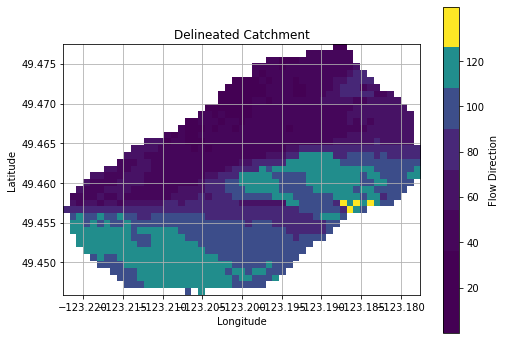

In [89]:
print('')
print('A map of the catchment:')

# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)

im = ax.imshow(catch, extent=grid.extent, zorder=1, cmap='viridis')
plt.colorbar(im, ax=ax, values=sorted(dirmap), label='Flow Direction')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment')
# plt.savefig('data/img/catchment.png', bbox_inches='tight')

In [90]:
print('')
print('Average slope of catchment is:',np.nanmean(slope),'m/m')
print('')
print('The mean elevation of the catchment is:',np.nanmean(dem_small),'m')
print('')
print('The steepest slope in the catchment is:',np.nanmax(slope),'m/m')
print('')
print('The longest flow distance in the catchment is:',np.nanmax(grid.dist2),'m')
print('')


Average slope of catchment is: 0.3243133448809133 m/m

The mean elevation of the catchment is: 1059.5763575042158 m

The steepest slope in the catchment is: 0.5889986741713974 m/m

The longest flow distance in the catchment is: 4185.314652460284 m

